In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

## Step 1: Explore the dataset

Our ‘train’ folder contains 43 folders each representing a different class. The range of the folder is from 0 to 42. With the help of the OS module, we iterate over all the classes and append images and their respective labels in the data and labels list.

The PIL library is used to open image content into an array.

In [8]:
data = []
labels = []
classes = 43          # we have 43 different signs
curr_dir = os.getcwd()  # getcwd()  returns current working directory of a process

for i in range(classes):
    path = os.path.join(curr_dir, 'Train', str(i))
    images = os.listdir(path)

    for a in images:
      try:
          img = Image.open(path + '\\' + a)
          img = img.resize((30, 30))
          img = np.array(img)
          data.append(img)
          labels.append(i)
      except:
          print("Error Loading Image")

data    = np.array(data)
labels  = np.array(labels)

Finally, we have stored all the images and their labels into lists (data and labels).

We need to convert the list into numpy arrays for feeding to the model.

The shape of data is (39209, 30, 30, 3) which means that there are 39,209 images of size 30×30 pixels and the last 3 means the data contains colored images (RGB value).

With the sklearn package, we use the train_test_split() method to split training and testing data.

From the keras.utils package, we use to_categorical method to convert the labels present in y_train and t_test into one-hot encoding.

In [17]:
print(data.shape, labels.shape)

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state = 42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

(39209, 30, 30, 3) (39209,)
(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


## Step 2: Build a CNN model

To classify the images into their respective categories, we will build a CNN model (Convolutional Neural Network). CNN is best for image classification purposes.


The architecture of our model is:

- 2 Conv2D layer (filter=32, kernel_size=(5,5), activation=”relu”)

- MaxPool2D layer ( pool_size=(2,2))

- Dropout layer (rate=0.25)

- 2 Conv2D layer (filter=64, kernel_size=(3,3), activation=”relu”)

- MaxPool2D layer ( pool_size=(2,2))

- Dropout layer (rate=0.25)

- Flatten layer to squeeze the layers into 1 dimension

- Dense Fully connected layer (256 nodes, activation=”relu”)

- Dropout layer (rate=0.5)

- Dense layer (43 nodes, activation=”softmax”)

We compile the model with Adam optimizer which performs well and loss is “categorical_crossentropy” because we have multiple classes to categorise.



In [29]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))  # output layer ==> 43 classes

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Steps 3: Train and validate the model

After building the model architecture, we then train the model using model.fit(). I tried with batch size 32 and 64. 

Our model performed better with 64 batch size. And after 15 epochs the accuracy was stable.

In [30]:
epochs= 15
result = model.fit(x_train, y_train, batch_size=64, epochs=epochs, validation_data = (x_test, y_test))

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
490/491 [============================>.] - ETA: 0s - loss: 2.2700 - accuracy: 0.4575WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000024600C73A68> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

# accuracy: 96%
Our model got a 96% accuracy on the training dataset.
With matplotlib, we plot the graph for accuracy and the loss

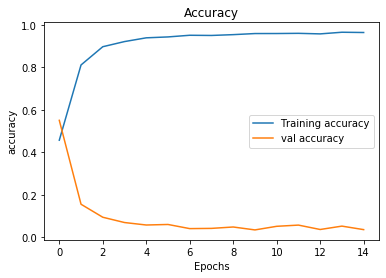

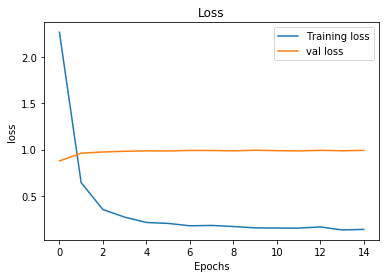

In [34]:
# draw accuracy plot
plt.figure(0)
plt.plot(result.history['accuracy'], label="Training accuracy")
plt.plot(result.history['val_loss'], label='val accuracy')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend()

# draw Loss plot
plt.figure(1)
plt.plot(result.history['loss'], label="Training loss")
plt.plot(result.history['val_accuracy'], label='val loss')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()

# Step 4: Test our model with test dataset

Our dataset contains a test folder and in a test.csv file, we have the details related to the image path and their respective class labels. We extract the image path and labels using pandas. Then to predict the model, we have to resize our images to 30×30 pixels and make a numpy array containing all image data. From the sklearn.metrics, we imported the accuracy_score and observed how our model predicted the actual labels. We achieved a 95% accuracy in this model.

In [41]:
from sklearn.metrics import accuracy_score
import pandas as pd

y_test = pd.read_csv('Test.csv')
labels = y_test['ClassId'].values
images = y_test['Path'].values

data=[]

for img in images:
    im = Image.open(img)
    im = im.resize((30, 30))
    data.append(np.array(im))
    
x_test = np.array(data)

pred = model.predict_classes(x_test)

# Cheack Accuracy with unseen test_data
accuracy_score(labels, pred)

0.9607284243863816

In the end, we are going to save the model that we have trained using the Keras model.save() function

In [38]:
model.save('traffic_signs_classifier.h5')